In [1]:
import cv2
import os

# Path to the input video file
video_file = 'Data.avi'

# Create a directory for storing frames if it doesn't exist
output_dir = 'raw-frames'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open the video file
cap = cv2.VideoCapture(video_file)

# Initialize variables
frame_count = 0
frame_rate = 0.5  # Number of seconds per frame

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # If the video has ended, break the loop
    if not ret:
        break

    # Calculate the time in seconds
    time_in_seconds = frame_count / cap.get(cv2.CAP_PROP_FPS)

    # Check if it's time to save a frame (every 10 seconds)
    if time_in_seconds % frame_rate == 0:
        # Construct the output filename
        output_file = os.path.join(output_dir, f'frame_{frame_count}.jpg')

        # Save the frame as an image
        cv2.imwrite(output_file, frame)

    # Increment the frame count
    frame_count += 1

# Release the video capture object and close any open windows
cap.release()
cv2.destroyAllWindows()

print(f"Frames extracted and saved in '{output_dir}'")

Frames extracted and saved in 'raw-frames'


In [2]:
import os
import cv2

# Define the input folder containing the segmented images
image_folder = "raw-frames"

# Create the output directory for augmented images if it doesn't exist
augmented_image_folder = "augmented_images"
os.makedirs(augmented_image_folder, exist_ok=True)

# Function to apply image augmentation
def augment_image(image):
    # Define the augmentation operations you want to apply here.
    # For example, you can apply operations like rotation, flipping, brightness adjustment, etc.
    # Here, we'll demonstrate rotation and horizontal flipping as examples.

    # Rotate the image (you can specify the angle)
    rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

    # Horizontal flip the image
    flipped_image = cv2.flip(image, 1)

    return [rotated_image, flipped_image]

# Iterate through the segmented images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_folder, filename)

        # Read the segmented image
        image = cv2.imread(image_path)

        # Augment the image
        augmented_images = augment_image(image)

        # Save augmented images with new filenames
        for i, augmented_image in enumerate(augmented_images):
            augmented_filename = f"{filename.replace('.jpg', '')}%augmented_{i}.jpg"
            augmented_image_path = os.path.join(augmented_image_folder, augmented_filename)
            cv2.imwrite(augmented_image_path, augmented_image)

# Print a message indicating the completion
print("Augmented images saved in the 'augmented_images' folder.")

Augmented images saved in the 'augmented_images' folder.


Overall Accuracy: 0.8857715430861723
Overall Confusion Matrix:
[[4838 1140]
 [   0 4002]]


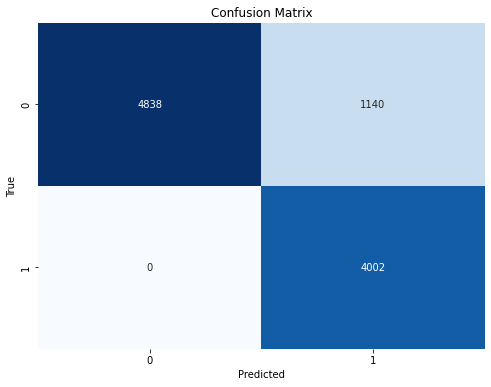

In [37]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the folder containing your segmented images.
IMAGE_FOLDER = 'augmented_images'

# Set the threshold for classifying as "cloud" or "background."
threshold = 128

# Define the lower and upper bounds of the blue color
lower_blue = np.array([90, 100, 100], dtype=np.uint8)
upper_blue = np.array([140, 255, 255], dtype=np.uint8)

def preprocess_image(image):
    if image is not None:
        # Convert the image to HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Create a binary mask based on the blue color range
        mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

        # Create "cloud" and "background" images based on the mask
        cloud = cv2.bitwise_and(image, image, mask=mask)
        background = cv2.bitwise_and(image, image, mask=~mask)

        return cloud.flatten(), background.flatten()
    else:
        return None, None

# Load and preprocess the dataset in batches
all_cloud_images = []
all_background_images = []
all_labels = []

batch_size = 50  # Set the batch size

for filename in os.listdir(IMAGE_FOLDER):
    image = cv2.imread(os.path.join(IMAGE_FOLDER, filename), cv2.IMREAD_COLOR)

    cloud_image, background_image = preprocess_image(image)

    if cloud_image is not None and background_image is not None:
        all_cloud_images.append(cloud_image.flatten())
        all_background_images.append(background_image.flatten())
        all_labels.append(0) if 'cloud' in filename else all_labels.append(1)  # Corrected labeling

        # Train the model in batches
        if len(all_cloud_images) == batch_size:
            # Combine the data for training
            X_cloud = np.array(all_cloud_images)
            X_background = np.array(all_background_images)
            X = np.concatenate((X_cloud, X_background), axis=0)

            # Create labels for cloud and background (corrected)
            labels_cloud = [0] * len(all_cloud_images)
            labels_background = [1] * len(all_background_images)
            y_cloud = np.array(labels_cloud)
            y_background = np.array(labels_background)
            y = np.concatenate((y_cloud, y_background), axis=0)

            # Split the dataset into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Create an SVM classifier with a custom C value
            custom_C = 1000  # You can adjust this value as needed
            clf = SVC(C=custom_C, kernel='sigmoid')

            # Train the SVM model
            clf.fit(X_train, y_train)

            # Make predictions on the test set
            y_pred = clf.predict(X_test)

            # Append predictions and true labels for all batches
            if 'all_y_pred' in locals():
                all_y_pred = np.concatenate((all_y_pred, y_pred), axis=0)
                all_y_true = np.concatenate((all_y_true, y_test), axis=0)
            else:
                all_y_pred = y_pred
                all_y_true = y_test

            # Reset the batch data
            all_cloud_images = []
            all_background_images = []
            all_labels = []

# Process any remaining images in the last batch
if all_cloud_images and all_background_images:
    # Combine the data for training
    X_cloud = np.array(all_cloud_images)
    X_background = np.array(all_background_images)
    X = np.concatenate((X_cloud, X_background), axis=0)

    # Create labels for cloud and background (corrected)
    labels_cloud = [0] * len(all_cloud_images)
    labels_background = [1] * len(all_background_images)
    y_cloud = np.array(labels_cloud)
    y_background = np.array(labels_background)
    y = np.concatenate((y_cloud, y_background), axis=0)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create an SVM classifier with a custom C value
    custom_C = 1000 # You can adjust this value as needed
    clf = SVC(C=custom_C, kernel='sigmoid')

    # Train the SVM model
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Append predictions and true labels for the last batch
    all_y_pred = np.concatenate((all_y_pred, y_pred), axis=0)
    all_y_true = np.concatenate((all_y_true, y_test), axis=0)

# Calculate accuracy on the combined test set
overall_accuracy = accuracy_score(all_y_true, all_y_pred)

# Print the overall accuracy
print('Overall Accuracy:', overall_accuracy)

# Print the confusion matrix for the combined test set
overall_conf_matrix = confusion_matrix(all_y_true, all_y_pred)
print('Overall Confusion Matrix:')
print(overall_conf_matrix)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


